In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

import collections

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors

import gc

seed=15

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
gc.collect()

37

# Lectura y tratamiento de los datos

In [3]:
%%time
df_train = pd.read_parquet('../data/df_filt_train_100_100.zip')
df_train.shape

Wall time: 729 ms


(8556951, 3)

In [4]:
%%time
encoder_mv = LabelEncoder()
df_train['movie_id_orig'] = df_train['movie_id'].astype(str)
df_train['movie_id'] = encoder_mv.fit_transform(df_train['movie_id_orig'])

encoder_usr = LabelEncoder()
df_train['user_id_orig'] = df_train['user_id'].astype(str)
df_train['user_id'] = encoder_usr.fit_transform(df_train['user_id_orig'])

Wall time: 27.6 s


In [5]:
users = df_train["user_id"].drop_duplicates()
movies = df_train["movie_id"].drop_duplicates()

In [6]:
translate_users = df_train[["user_id","user_id_orig"]].drop_duplicates().set_index('user_id')
translate_movies = df_train[["movie_id","movie_id_orig"]].drop_duplicates().set_index('movie_id')

translate_users.to_csv('translate_users_tts_100_100.csv')
translate_movies.to_csv('translate_movies_tts_100_100.csv')

translate_users.head(10)

,user_id_orig
user_id,
31206,2000429
55088,382224
19393,1617455
13510,143113
67063,768876
39310,2261348
45195,2451473
42445,2364018
34650,2110908


In [7]:
users.shape

(74452,)

In [8]:
users.max()

74451

In [9]:
movies.shape

(7027,)

In [10]:
movies.max()

7026

# Entrenamiento del modelo

In [11]:
class CFModel(object):
	"""Simple class that represents a collaborative filtering model"""
	def __init__(self, embedding_vars, loss, metrics=None):
		""""Initializes a CFModel.
		Args:
			embedding_vars: A dictionary of tf.Variables.
			loss: A float Tensor. The loss to optimize.
			metrics: optional list of dictionaries of Tensors. The metrics in each
			dictionary will be plotted in a separate figure during training.
		"""
		self._embedding_vars = embedding_vars
		self._loss = loss
		self._metrics = metrics
		self._embeddings = {k: None for k in embedding_vars}
		self._session = None

	@property
	def embeddings(self):
		"""The embeddings dictionary."""
		return self._embeddings

	def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
			  optimizer=tf.train.GradientDescentOptimizer):
		"""Trains the model.
		Args:
			iterations: number of iterations to run.
			learning_rate: optimizer learning rate.
			plot_results: whether to plot the results at the end of training.
			optimizer: the optimizer to use. Default to GradientDescentOptimizer.
		Returns:
			The metrics dictionary evaluated at the last iteration.
		"""
		with self._loss.graph.as_default():
			opt = optimizer(learning_rate)
			train_op = opt.minimize(self._loss)
			local_init_op = tf.group(tf.variables_initializer(opt.variables()),
									 tf.local_variables_initializer())
			if self._session is None:
				self._session = tf.Session()
				with self._session.as_default():
					self._session.run(tf.global_variables_initializer())
					self._session.run(tf.tables_initializer())
					tf.train.start_queue_runners()
		with self._session.as_default():
			local_init_op.run()
			iterations = []
			metrics = self._metrics or ({},)
			metrics_vals = [collections.defaultdict(list) for _ in self._metrics]
			# Train and append results.
			for i in range(num_iterations + 1):
				#print(i)
				_, results = self._session.run((train_op, metrics))
				if (i % 500 == 0) or i == num_iterations:
					print("Iteration %d: " % i + ", ".join(["%s=%f" % (k, v) for r in results for k, v in r.items()]))
					iterations.append(i)
					for metric_val, result in zip(metrics_vals, results):
						for k, v in result.items():
							metric_val[k].append(v)
			for k, v in self._embedding_vars.items():
				self._embeddings[k] = v.eval()
			if plot_results:
				# Plot the metrics.
				num_subplots = len(metrics)+1
				fig = plt.figure()
				fig.set_size_inches(num_subplots*10, 8)
				for i, metric_vals in enumerate(metrics_vals):
					ax = fig.add_subplot(1, num_subplots, i+1)
					for k, v in metric_vals.items():
						ax.plot(iterations, v, label=k)
					ax.set_xlim([1, num_iterations])
					ax.legend()
			return results



def build_model(ratings, embedding_dim=3, init_stddev=1.):
	"""
	Args:
		ratings: a DataFrame of the ratings
		embedding_dim: the dimension of the embedding vectors.
		init_stddev: float, the standard deviation of the random initial embeddings.
	Returns:
		model: a CFModel.
	"""
	# Split the ratings DataFrame into train and test.
	train_ratings, test_ratings = split_dataframe(ratings)
	# SparseTensor representation of the train and test datasets.
	A_train = build_rating_sparse_tensor(train_ratings)
	A_test = build_rating_sparse_tensor(test_ratings)
	# Initialize the embeddings using a normal distribution.
	U = tf.Variable(tf.random_normal(
			[A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
	V = tf.Variable(tf.random_normal(
			[A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
	train_loss = sparse_mean_square_error(A_train, U, V)
	test_loss = sparse_mean_square_error(A_test, U, V)
	metrics = {
			'train_error': train_loss,
			'val_error': test_loss
	}
	embeddings = {
			"user_id": U,
			"movie_id": V
	}
	return CFModel(embeddings, train_loss, [metrics])



# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
	"""Splits a DataFrame into training and test sets.
	Args:
		df: a dataframe.
		holdout_fraction: fraction of dataframe rows to use in the test set.
	Returns:
		train: dataframe for training
		test: dataframe for testing
	"""
	test = df.sample(frac=holdout_fraction, replace=False)
	train = df[~df.index.isin(test.index)]
	return train, test



#@title Solution
def build_rating_sparse_tensor(ratings_df):
	"""
	Args:
		ratings_df: a pd.DataFrame with `user_id`, `movie_id` and `rating` columns.
	Returns:
		a tf.SparseTensor representing the ratings matrix.
	"""
	indices = ratings_df[['user_id', 'movie_id']].values
	values = ratings_df['rating'].values
	return tf.SparseTensor(
			indices=indices,
			values=values,
			dense_shape=[users.shape[0], movies.shape[0]])



def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
	"""
	Args:
		sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
		user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
			dimension, such that U_i is the embedding of user i.
		movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
			dimension, such that V_j is the embedding of movie j.
	Returns:
		A scalar Tensor representing the MSE between the true ratings and the
			model's predictions.
	"""
	predictions = tf.reduce_sum(
			tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
			tf.gather(movie_embeddings, sparse_ratings.indices[:, 1]),
			axis=1)
	loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
	return loss

print('ejecutó')

ejecutó


In [12]:
gc.collect()

15

Iteration 0: train_error=24.026587, val_error=23.992872
Iteration 500: train_error=17.569752, val_error=17.601007
Iteration 1000: train_error=16.204056, val_error=16.269491
Iteration 1500: train_error=15.608693, val_error=15.696093
Iteration 2000: train_error=15.264694, val_error=15.367805
Iteration 2500: train_error=15.036186, val_error=15.151413
Iteration 3000: train_error=14.870466, val_error=14.995532
Iteration 3500: train_error=14.742219, val_error=14.875583
Iteration 4000: train_error=14.637294, val_error=14.777870
Iteration 4500: train_error=14.546638, val_error=14.693642
Iteration 5000: train_error=14.463579, val_error=14.616439
Iteration 5500: train_error=14.382371, val_error=14.540691
Iteration 6000: train_error=14.297278, val_error=14.460804
Iteration 6500: train_error=14.201854, val_error=14.370465
Iteration 7000: train_error=14.088331, val_error=14.262031
Iteration 7500: train_error=13.947067, val_error=14.125986
Iteration 8000: train_error=13.766137, val_error=13.950538
I

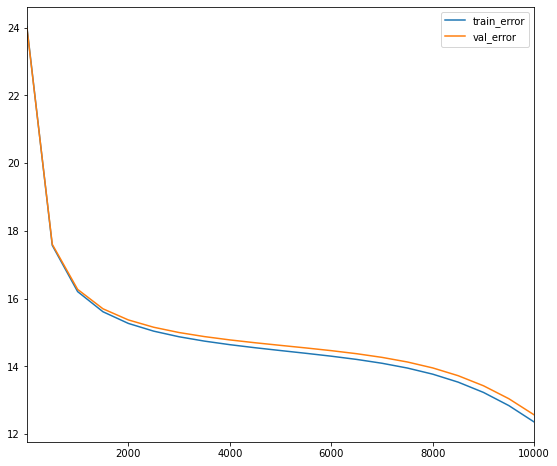

In [13]:
%%time

emb_dim = 10
lr = 1
lr_str = str(lr)
niter = 10000
niter_str = "10k"

model = build_model(df_train, embedding_dim=emb_dim, init_stddev=1)
model.train(num_iterations=niter, learning_rate=lr)

user_embedding = model.embeddings["user_id"]
movie_embedding = model.embeddings["movie_id"]

np.save(f'./embeddings/user_embeddings_dim{emb_dim}_{lr_str}_{niter_str}.npy', user_embedding)
np.save(f'./embeddings/movie_embeddings_dim{emb_dim}_{lr_str}_{niter_str}.npy', movie_embedding)

In [14]:
gc.collect()

2968

Iteration 0: train_error=23.980890, val_error=23.953190
Iteration 500: train_error=14.482498, val_error=14.642558
Iteration 1000: train_error=13.150011, val_error=13.347032
Iteration 1500: train_error=6.464273, val_error=6.668565
Iteration 2000: train_error=2.588330, val_error=2.747512
Iteration 2500: train_error=1.494944, val_error=1.618359
Iteration 3000: train_error=1.149692, val_error=1.252640
Iteration 3500: train_error=1.015496, val_error=1.106485
Iteration 4000: train_error=0.951768, val_error=1.035131
Iteration 4500: train_error=0.916014, val_error=0.994048
Iteration 5000: train_error=0.893302, val_error=0.967320
Iteration 5500: train_error=0.877580, val_error=0.948403
Iteration 6000: train_error=0.866045, val_error=0.934227
Iteration 6500: train_error=0.857241, val_error=0.923182
Iteration 7000: train_error=0.850327, val_error=0.914334
Iteration 7500: train_error=0.844782, val_error=0.907096
Iteration 8000: train_error=0.840261, val_error=0.901078
Iteration 8500: train_error=0

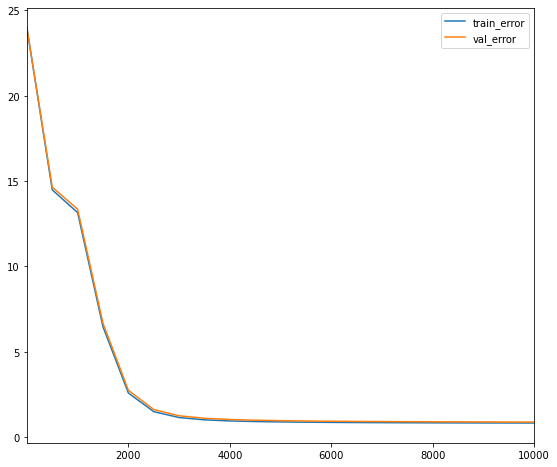

In [15]:
%%time

emb_dim = 10
lr = 10
lr_str = str(lr)
niter = 10000
niter_str = "10k"

model = build_model(df_train, embedding_dim=emb_dim, init_stddev=1)
model.train(num_iterations=niter, learning_rate=lr)

user_embedding = model.embeddings["user_id"]
movie_embedding = model.embeddings["movie_id"]

np.save(f'./embeddings/user_embeddings_dim{emb_dim}_{lr_str}_{niter_str}.npy', user_embedding)
np.save(f'./embeddings/movie_embeddings_dim{emb_dim}_{lr_str}_{niter_str}.npy', movie_embedding)

In [16]:
gc.collect()

2908

Iteration 0: train_error=24.073652, val_error=24.042139
Iteration 500: train_error=12.393298, val_error=12.561552
Iteration 1000: train_error=2.291298, val_error=2.433461
Iteration 1500: train_error=1.121990, val_error=1.219009
Iteration 2000: train_error=0.946402, val_error=1.026938
Iteration 2500: train_error=0.891450, val_error=0.963682
Iteration 3000: train_error=0.865149, val_error=0.931956
Iteration 3500: train_error=0.849813, val_error=0.912625
Iteration 4000: train_error=0.839943, val_error=0.899651
Iteration 4500: train_error=0.833196, val_error=0.890426
Iteration 5000: train_error=0.828382, val_error=0.883598
Iteration 5500: train_error=0.824828, val_error=0.878389
Iteration 6000: train_error=0.822128, val_error=0.874315
Iteration 6500: train_error=0.820028, val_error=0.871065
Iteration 7000: train_error=0.818358, val_error=0.868426
Iteration 7500: train_error=0.817006, val_error=0.866251
Iteration 8000: train_error=0.815893, val_error=0.864436
Iteration 8500: train_error=0.8

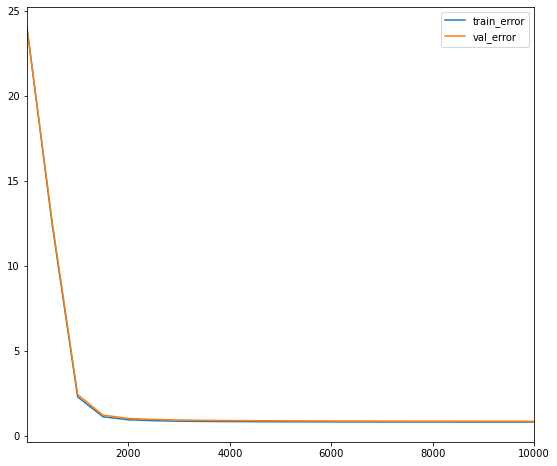

In [17]:
%%time

emb_dim = 10
lr = 20
lr_str = str(lr)
niter = 10000
niter_str = "10k"

model = build_model(df_train, embedding_dim=emb_dim, init_stddev=1)
model.train(num_iterations=niter, learning_rate=lr)

user_embedding = model.embeddings["user_id"]
movie_embedding = model.embeddings["movie_id"]

np.save(f'./embeddings/user_embeddings_dim{emb_dim}_{lr_str}_{niter_str}.npy', user_embedding)
np.save(f'./embeddings/movie_embeddings_dim{emb_dim}_{lr_str}_{niter_str}.npy', movie_embedding)

In [18]:
gc.collect()

2908